In [3]:
import os
import shutil
import random
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers, backend as K

In [11]:
# ---------------------------
# PATH & PARAMETER
# ---------------------------
raw_data_dir = "D:\DATASET"
preprocessed_dir = "D:\Preprocessed"
split_data_dir = "D:\Split"
target_size = (224, 224)
batch_size = 32
num_classes = 4
epochs = 100

In [5]:
# ---------------------------
# 1. PREPROCESS (convert ke RGB, resize, normalisasi, save)
# ---------------------------
def preprocess_and_save(source_dir, dest_dir, target_size=(224, 224)):
    if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
        for class_name in os.listdir(source_dir):
            src_path = os.path.join(source_dir, class_name)
            dst_path = os.path.join(dest_dir, class_name)
            os.makedirs(dst_path, exist_ok=True)

            for img_name in os.listdir(src_path):
                img_path = os.path.join(src_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")  # paksa semua gambar jadi RGB
                    img = img.resize(target_size)

                    # Normalisasi piksel ke [0,1]
                    img_array = np.asarray(img).astype(np.float32) / 255.0

                    # Simpan kembali hasil normalisasi (RGB)
                    save_img = Image.fromarray((img_array * 255).astype(np.uint8))
                    save_path = os.path.join(dst_path, img_name)
                    save_img.save(save_path)
                except Exception as e:
                    print(f"Gagal memproses {img_path}: {e}")

        print(f"Preprocessing selesai dan disimpan : {dest_dir}")
    else:
        print(f"Preprocessed data sudah ada di: {dest_dir}")

In [6]:
# ---------------------------
# 2. SPLIT DATA (train/val/test)
# ---------------------------
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(os.path.join(dest_dir, 'train')) or not os.listdir(os.path.join(dest_dir, 'train')):
        for class_name in os.listdir(source_dir):
            src_class = os.path.join(source_dir, class_name)
            images = os.listdir(src_class)
            random.shuffle(images)
            total = len(images)
            train_end = int(train_ratio * total)
            val_end = train_end + int(val_ratio * total)

            for i, img_name in enumerate(images):
                subset = "train" if i < train_end else "val" if i < val_end else "test"
                dst_path = os.path.join(dest_dir, subset, class_name)
                os.makedirs(dst_path, exist_ok=True)
                shutil.copy(os.path.join(src_class, img_name), os.path.join(dst_path, img_name))

        print(f"Data telah di-split dan disimpan di: {dest_dir}")
    else:
        print(f"Data sudah ada di folder {dest_dir}, split tidak dilakukan.")

# ---------------------------
# JALANKAN
# ---------------------------
preprocess_and_save(raw_data_dir, preprocessed_dir, target_size=(224, 224))
split_data(preprocessed_dir, split_data_dir)

Preprocessed data sudah ada di: D:\Preprocessed
Data sudah ada di folder D:\Split, split tidak dilakukan.


In [5]:
import os
from PIL import Image

def check_image_color_modes(image_dirs):
    mode_count = {'RGB': 0, 'Grayscale': 0, 'Other': 0}
    error_files = []

    # Iterate through all directories in the list
    for image_dir in image_dirs:
        print(f"Memeriksa folder: {image_dir}")
        
        # Iterate through all images in the directory
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(root, file)

                    try:
                        # Buka gambar dengan PIL
                        with Image.open(img_path) as pil_img:
                            mode = pil_img.mode

                            if mode == 'RGB':
                                mode_count['RGB'] += 1
                            elif mode == 'L':  # Mode 'L' adalah Grayscale di PIL
                                mode_count['Grayscale'] += 1
                            else:
                                mode_count['Other'] += 1
                    except Exception as e:
                        error_files.append(f"Error loading {file}: {e}")

    # Print the results
    print("\n=== HASIL DETEKSI TIPE GAMBAR ===")
    for mode, count in mode_count.items():
        print(f"{mode}: {count} gambar")

    if error_files:
        print(f"\n❌ Gagal memproses beberapa file:")
        for error in error_files:
            print(f"- {error}")

# Ganti dengan tiga path dataset kamu
image_dirs = [
    "E:\DATASET",  # Contoh direktori, sesuaikan dengan data kamu
    "E:\Preprocessed",
    "E:\Split"
]

# Panggil fungsi untuk memeriksa mode gambar
check_image_color_modes(image_dirs)


Memeriksa folder: E:\DATASET
Memeriksa folder: E:\Preprocessed
Memeriksa folder: E:\Split

=== HASIL DETEKSI TIPE GAMBAR ===
RGB: 24861 gambar
Grayscale: 0 gambar
Other: 0 gambar


In [6]:
def check_normalized_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))  # Sesuai ukuran target
                img_array = np.array(img).astype(np.float32) / 255.0  # Normalisasi sementara

                if not ((img_array >= 0.0).all() and (img_array <= 1.0).all()):
                    print(f"[!] Gambar TIDAK ter-normalisasi: {img_path}")
                    return False
    print("✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)")
    return True

# Ganti dengan direktori val dan test kamu
val_ok = check_normalized_images(os.path.join(split_data_dir, 'val'))
test_ok = check_normalized_images(os.path.join(split_data_dir, 'test'))


✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)
✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)


In [7]:
# ---------------------------
# 3. DATA GENERATOR (tanpa rescale)
# ---------------------------

train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.6, 1.4],
    channel_shift_range=30.0,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator()  # Tidak pakai rescale

train_generator = train_gen.flow_from_directory(
    os.path.join(split_data_dir, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_gen.flow_from_directory(
    os.path.join(split_data_dir, "val"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_gen.flow_from_directory(
    os.path.join(split_data_dir, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5800 images belonging to 4 classes.
Found 1241 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K

# ---------------------------
# BOTTLENECK BLOCK
# ---------------------------
def bottleneck_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # 1x1 conv
    x = layers.Conv2D(filters, 1, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3 conv
    x = layers.Conv2D(filters, 3, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 1x1 conv
    x = layers.Conv2D(filters * 4, 1, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ---------------------------
# BUILD RESNET152 MODEL
# ---------------------------
def build_resnet152(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Conv2_x: 3 bottleneck blocks
    for i in range(3):
        x = bottleneck_block(x, 64, stride=1, downsample=(i == 0))

    # Conv3_x: 8 bottleneck blocks
    for i in range(8):
        x = bottleneck_block(x, 128, stride=2 if i == 0 else 1, downsample=(i == 0))

    # Conv4_x: 36 bottleneck blocks
    for i in range(36):
        x = bottleneck_block(x, 256, stride=2 if i == 0 else 1, downsample=(i == 0))

    # Conv5_x: 3 bottleneck blocks
    for i in range(3):
        x = bottleneck_block(x, 512, stride=2 if i == 0 else 1, downsample=(i == 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# ---------------------------
# FOCAL LOSS FUNCTION
# ---------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# ---------------------------
# COMPILE MODEL
# ---------------------------
model = build_resnet152(input_shape=(224, 224, 3), num_classes=4)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=focal_loss(),
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_155[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_151 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_151[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_156 (Conv2D) │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_156[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_152 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_157 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_152[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_157[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_153 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_158 (Conv2D) │ (None, 56, 56,    │     16,640 │ re_lu_153[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_159 (Conv2D) │ (None, 56, 56,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_158[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_159[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_154 (ReLU)    │ (None, 56, 56,    │          0 │ add_50[0][0]    

 Total params: 59,422,084 (226.68 MB)

 Trainable params: 59,270,660 (226.10 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [13]:
# ---------------------------
# 5. CALLBACKS
# ---------------------------
checkpoint = ModelCheckpoint('Model_Terbaik_Tahap 1_resnet152.h5', monitor='val_accuracy', save_best_only=True)
checkpoint_keras = ModelCheckpoint('Model Terbaik_Tahap 1 keras.keras', monitor='val_accuracy', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [14]:
# ---------------------------
# 6. TRAINING
# ---------------------------
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.2430 - loss: 5.3038 

182/182 ━━━━━━━━━━━━━━━━━━━━ 3009s 16s/step - accuracy: 0.2431 - loss: 5.3034 - val_accuracy: 0.2546 - val_loss: 5.1174 - learning_rate: 1.0000e-04
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.2980 - loss: 5.0844 

182/182 ━━━━━━━━━━━━━━━━━━━━ 3240s 18s/step - accuracy: 0.2981 - loss: 5.0842 - val_accuracy: 0.3086 - val_loss: 4.9722 - learning_rate: 1.0000e-04
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2931s 16s/step - accuracy: 0.3330 - loss: 4.9290 - val_accuracy: 0.2740 - val_loss: 4.8133 - learning_rate: 1.0000e-04
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.3498 - loss: 4.7485 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2874s 16s/step - accuracy: 0.3498 - loss: 4.7482 - val_accuracy: 0.3183 - val_loss: 4.6091 - learning_rate: 1.0000e-04
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.3643 - loss: 4.5554 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2781s 15s/step - accuracy: 0.3643 - loss: 4.5551 - val_accuracy: 0.4142 - val_loss: 4.3875 - learning_rate: 1.0000e-04
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 73s/step - accuracy: 0.3606 - loss: 4.3453  

182/182 ━━━━━━━━━━━━━━━━━━━━ 13253s 73s/step - accuracy: 0.3606 - loss: 4.3450 - val_accuracy: 0.4263 - val_loss: 4.1734 - learning_rate: 1.0000e-04
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1911s 11s/step - accuracy: 0.3643 - loss: 4.1266 - val_accuracy: 0.4190 - val_loss: 3.9573 - learning_rate: 1.0000e-04
Epoch 8/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1899s 10s/step - accuracy: 0.3828 - loss: 3.9077 - val_accuracy: 0.4222 - val_loss: 3.7338 - learning_rate: 1.0000e-04
Epoch 9/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1903s 10s/step - accuracy: 0.3782 - loss: 3.6891 - val_accuracy: 0.3852 - val_loss: 3.5290 - learning_rate: 1.0000e-04
Epoch 10/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3795 - loss: 3.4714 

182/182 ━━━━━━━━━━━━━━━━━━━━ 1922s 11s/step - accuracy: 0.3796 - loss: 3.4711 - val_accuracy: 0.4359 - val_loss: 3.3039 - learning_rate: 1.0000e-04
Epoch 11/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1951s 11s/step - accuracy: 0.4102 - loss: 3.2618 - val_accuracy: 0.4271 - val_loss: 3.1042 - learning_rate: 1.0000e-04
Epoch 12/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2129s 12s/step - accuracy: 0.3984 - loss: 3.0591 - val_accuracy: 0.4053 - val_loss: 2.9094 - learning_rate: 1.0000e-04
Epoch 13/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2284s 13s/step - accuracy: 0.4106 - loss: 2.8665 - val_accuracy: 0.3610 - val_loss: 2.7481 - learning_rate: 1.0000e-04
Epoch 14/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2058s 11s/step - accuracy: 0.4311 - loss: 2.6840 - val_accuracy: 0.3263 - val_loss: 2.5812 - learning_rate: 1.0000e-04
Epoch 15/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4069 - loss: 2.5147 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2053s 11s/step - accuracy: 0.4070 - loss: 2.5145 - val_accuracy: 0.4819 - val_loss: 2.3797 - learning_rate: 1.0000e-04
Epoch 16/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2172s 12s/step - accuracy: 0.4299 - loss: 2.3527 - val_accuracy: 0.4545 - val_loss: 2.2404 - learning_rate: 1.0000e-04
Epoch 17/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.4385 - loss: 2.2044 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2556s 14s/step - accuracy: 0.4384 - loss: 2.2042 - val_accuracy: 0.5149 - val_loss: 2.0848 - learning_rate: 1.0000e-04
Epoch 18/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2053s 11s/step - accuracy: 0.4352 - loss: 2.0680 - val_accuracy: 0.4843 - val_loss: 1.9692 - learning_rate: 1.0000e-04
Epoch 19/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2032s 11s/step - accuracy: 0.4376 - loss: 1.9449 - val_accuracy: 0.4819 - val_loss: 1.8468 - learning_rate: 1.0000e-04
Epoch 20/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4645 - loss: 1.8267 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2050s 11s/step - accuracy: 0.4644 - loss: 1.8266 - val_accuracy: 0.5181 - val_loss: 1.7332 - learning_rate: 1.0000e-04
Epoch 21/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2154s 12s/step - accuracy: 0.4678 - loss: 1.7201 - val_accuracy: 0.4996 - val_loss: 1.6351 - learning_rate: 1.0000e-04
Epoch 22/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2486s 14s/step - accuracy: 0.4491 - loss: 1.6276 - val_accuracy: 0.3699 - val_loss: 1.5981 - learning_rate: 1.0000e-04
Epoch 23/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2070s 11s/step - accuracy: 0.4486 - loss: 1.5479 - val_accuracy: 0.4867 - val_loss: 1.4742 - learning_rate: 1.0000e-04
Epoch 24/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2206s 12s/step - accuracy: 0.4704 - loss: 1.4619 - val_accuracy: 0.4617 - val_loss: 1.4116 - learning_rate: 1.0000e-04
Epoch 25/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2032s 11s/step - accuracy: 0.4926 - loss: 1.3807 - val_accuracy: 0.5077 - val_loss: 1.3586 - learning_rate: 1.0000e-04
Epoch 26/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2311s

182/182 ━━━━━━━━━━━━━━━━━━━━ 2301s 13s/step - accuracy: 0.5472 - loss: 1.1901 - val_accuracy: 0.5890 - val_loss: 1.1407 - learning_rate: 1.0000e-04
Epoch 29/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2293s 13s/step - accuracy: 0.5669 - loss: 1.1336 - val_accuracy: 0.4537 - val_loss: 1.1616 - learning_rate: 1.0000e-04
Epoch 30/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2283s 13s/step - accuracy: 0.5911 - loss: 1.0823 - val_accuracy: 0.4940 - val_loss: 1.0801 - learning_rate: 1.0000e-04
Epoch 31/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6152 - loss: 1.0322 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2399s 13s/step - accuracy: 0.6152 - loss: 1.0322 - val_accuracy: 0.6293 - val_loss: 0.9848 - learning_rate: 1.0000e-04
Epoch 32/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6262 - loss: 0.9914 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2658s 15s/step - accuracy: 0.6262 - loss: 0.9914 - val_accuracy: 0.6809 - val_loss: 0.9471 - learning_rate: 1.0000e-04
Epoch 33/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2356s 13s/step - accuracy: 0.6286 - loss: 0.9510 - val_accuracy: 0.6454 - val_loss: 0.9214 - learning_rate: 1.0000e-04
Epoch 34/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2152s 12s/step - accuracy: 0.6539 - loss: 0.9167 - val_accuracy: 0.5173 - val_loss: 0.9291 - learning_rate: 1.0000e-04
Epoch 35/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2050s 11s/step - accuracy: 0.6708 - loss: 0.8815 - val_accuracy: 0.6753 - val_loss: 0.8609 - learning_rate: 1.0000e-04
Epoch 36/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2329s 13s/step - accuracy: 0.6730 - loss: 0.8534 - val_accuracy: 0.5641 - val_loss: 0.8489 - learning_rate: 1.0000e-04
Epoch 37/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2679s 15s/step - accuracy: 0.6781 - loss: 0.8227 - val_accuracy: 0.6301 - val_loss: 0.8120 - learning_rate: 1.0000e-04
Epoch 38/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2629s

182/182 ━━━━━━━━━━━━━━━━━━━━ 2622s 14s/step - accuracy: 0.6925 - loss: 0.7239 - val_accuracy: 0.7720 - val_loss: 0.6843 - learning_rate: 1.0000e-04
Epoch 42/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 17202s 95s/step - accuracy: 0.7162 - loss: 0.6968 - val_accuracy: 0.6777 - val_loss: 0.6969 - learning_rate: 1.0000e-04
Epoch 43/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2268s 12s/step - accuracy: 0.7123 - loss: 0.6794 - val_accuracy: 0.7059 - val_loss: 0.6651 - learning_rate: 1.0000e-04
Epoch 44/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2277s 13s/step - accuracy: 0.7315 - loss: 0.6601 - val_accuracy: 0.7309 - val_loss: 0.6408 - learning_rate: 1.0000e-04
Epoch 45/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2126s 12s/step - accuracy: 0.7279 - loss: 0.6417 - val_accuracy: 0.3981 - val_loss: 0.8151 - learning_rate: 1.0000e-04
Epoch 46/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2359s 13s/step - accuracy: 0.7103 - loss: 0.6341 - val_accuracy: 0.6680 - val_loss: 0.6320 - learning_rate: 1.0000e-04
Epoch 47/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2354

182/182 ━━━━━━━━━━━━━━━━━━━━ 2355s 13s/step - accuracy: 0.7392 - loss: 0.5534 - val_accuracy: 0.7832 - val_loss: 0.5275 - learning_rate: 1.0000e-04
Epoch 52/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2463s 14s/step - accuracy: 0.7650 - loss: 0.5364 - val_accuracy: 0.6438 - val_loss: 0.5490 - learning_rate: 1.0000e-04
Epoch 53/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2463s 14s/step - accuracy: 0.7481 - loss: 0.5272 - val_accuracy: 0.7164 - val_loss: 0.5230 - learning_rate: 1.0000e-04
Epoch 54/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2997s 16s/step - accuracy: 0.7600 - loss: 0.5107 - val_accuracy: 0.6519 - val_loss: 0.5442 - learning_rate: 1.0000e-04
Epoch 55/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2252s 12s/step - accuracy: 0.7539 - loss: 0.5000 - val_accuracy: 0.7599 - val_loss: 0.4924 - learning_rate: 1.0000e-04
Epoch 56/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2110s 12s/step - accuracy: 0.7563 - loss: 0.4863 - val_accuracy: 0.6986 - val_loss: 0.4932 - learning_rate: 1.0000e-04
Epoch 57/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1996s

182/182 ━━━━━━━━━━━━━━━━━━━━ 2104s 12s/step - accuracy: 0.7873 - loss: 0.4177 - val_accuracy: 0.8171 - val_loss: 0.4011 - learning_rate: 1.0000e-04
Epoch 64/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1967s 11s/step - accuracy: 0.7856 - loss: 0.4049 - val_accuracy: 0.6180 - val_loss: 0.5247 - learning_rate: 1.0000e-04
Epoch 65/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2576s 14s/step - accuracy: 0.7915 - loss: 0.3959 - val_accuracy: 0.5633 - val_loss: 0.4667 - learning_rate: 1.0000e-04
Epoch 66/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2613s 14s/step - accuracy: 0.7947 - loss: 0.3876 - val_accuracy: 0.5995 - val_loss: 0.4737 - learning_rate: 1.0000e-04
Epoch 67/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2340s 13s/step - accuracy: 0.7982 - loss: 0.3820 - val_accuracy: 0.6696 - val_loss: 0.4288 - learning_rate: 1.0000e-04
Epoch 68/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2228s 12s/step - accuracy: 0.7893 - loss: 0.3741 - val_accuracy: 0.6011 - val_loss: 0.6668 - learning_rate: 1.0000e-04
Epoch 69/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 13

182/182 ━━━━━━━━━━━━━━━━━━━━ 2518s 14s/step - accuracy: 0.8055 - loss: 0.3643 - val_accuracy: 0.8413 - val_loss: 0.3478 - learning_rate: 5.0000e-05
Epoch 70/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 21259s 117s/step - accuracy: 0.8375 - loss: 0.3519 - val_accuracy: 0.8251 - val_loss: 0.3449 - learning_rate: 5.0000e-05
Epoch 71/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2626s 14s/step - accuracy: 0.8374 - loss: 0.3446 - val_accuracy: 0.7840 - val_loss: 0.3528 - learning_rate: 5.0000e-05
Epoch 72/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2268s 12s/step - accuracy: 0.8409 - loss: 0.3407 - val_accuracy: 0.8276 - val_loss: 0.3404 - learning_rate: 5.0000e-05
Epoch 73/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8456 - loss: 0.3333 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2253s 12s/step - accuracy: 0.8456 - loss: 0.3333 - val_accuracy: 0.8485 - val_loss: 0.3291 - learning_rate: 5.0000e-05
Epoch 74/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2381s 13s/step - accuracy: 0.8526 - loss: 0.3271 - val_accuracy: 0.7712 - val_loss: 0.3588 - learning_rate: 5.0000e-05
Epoch 75/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2288s 13s/step - accuracy: 0.8408 - loss: 0.3287 - val_accuracy: 0.7977 - val_loss: 0.3381 - learning_rate: 5.0000e-05
Epoch 76/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2313s 13s/step - accuracy: 0.8430 - loss: 0.3235 - val_accuracy: 0.8219 - val_loss: 0.3301 - learning_rate: 5.0000e-05
Epoch 77/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2371s 13s/step - accuracy: 0.8447 - loss: 0.3197 - val_accuracy: 0.7687 - val_loss: 0.3517 - learning_rate: 5.0000e-05
Epoch 78/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2373s 13s/step - accuracy: 0.8367 - loss: 0.3157 - val_accuracy: 0.7486 - val_loss: 0.3725 - learning_rate: 5.0000e-05
Epoch 79/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 13

182/182 ━━━━━━━━━━━━━━━━━━━━ 2528s 14s/step - accuracy: 0.8521 - loss: 0.3125 - val_accuracy: 0.8678 - val_loss: 0.3097 - learning_rate: 2.5000e-05
Epoch 80/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2882s 16s/step - accuracy: 0.8748 - loss: 0.3027 - val_accuracy: 0.8582 - val_loss: 0.3089 - learning_rate: 2.5000e-05
Epoch 81/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2343s 13s/step - accuracy: 0.8739 - loss: 0.3024 - val_accuracy: 0.8638 - val_loss: 0.3050 - learning_rate: 2.5000e-05
Epoch 82/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 3219s 18s/step - accuracy: 0.8680 - loss: 0.3025 - val_accuracy: 0.8678 - val_loss: 0.3015 - learning_rate: 2.5000e-05
Epoch 83/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8739 - loss: 0.2949 

182/182 ━━━━━━━━━━━━━━━━━━━━ 2439s 13s/step - accuracy: 0.8739 - loss: 0.2949 - val_accuracy: 0.8743 - val_loss: 0.3050 - learning_rate: 2.5000e-05
Epoch 84/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2534s 14s/step - accuracy: 0.8764 - loss: 0.2978 - val_accuracy: 0.8533 - val_loss: 0.3081 - learning_rate: 2.5000e-05
Epoch 85/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2252s 12s/step - accuracy: 0.8854 - loss: 0.2924 - val_accuracy: 0.8082 - val_loss: 0.3156 - learning_rate: 2.5000e-05
Epoch 86/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2444s 13s/step - accuracy: 0.8828 - loss: 0.2929 - val_accuracy: 0.8719 - val_loss: 0.3068 - learning_rate: 2.5000e-05
Epoch 87/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8782 - loss: 0.2911 

182/182 ━━━━━━━━━━━━━━━━━━━━ 5242s 29s/step - accuracy: 0.8783 - loss: 0.2911 - val_accuracy: 0.8751 - val_loss: 0.3008 - learning_rate: 2.5000e-05
Epoch 88/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 3218s 18s/step - accuracy: 0.8826 - loss: 0.2894 - val_accuracy: 0.8614 - val_loss: 0.3005 - learning_rate: 2.5000e-05
Epoch 89/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2445s 13s/step - accuracy: 0.8861 - loss: 0.2861 - val_accuracy: 0.7969 - val_loss: 0.3261 - learning_rate: 2.5000e-05
Epoch 90/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2260s 12s/step - accuracy: 0.8870 - loss: 0.2874 - val_accuracy: 0.8687 - val_loss: 0.2987 - learning_rate: 2.5000e-05
Epoch 91/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2377s 13s/step - accuracy: 0.8943 - loss: 0.2815 - val_accuracy: 0.8654 - val_loss: 0.2962 - learning_rate: 2.5000e-05
Epoch 92/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2638s 14s/step - accuracy: 0.8889 - loss: 0.2808 - val_accuracy: 0.8654 - val_loss: 0.2929 - learning_rate: 2.5000e-05
Epoch 93/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 13

182/182 ━━━━━━━━━━━━━━━━━━━━ 24848s 137s/step - accuracy: 0.8998 - loss: 0.2788 - val_accuracy: 0.8767 - val_loss: 0.2959 - learning_rate: 2.5000e-05
Epoch 94/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2139s 12s/step - accuracy: 0.9093 - loss: 0.2759 - val_accuracy: 0.6116 - val_loss: 0.4531 - learning_rate: 2.5000e-05
Epoch 95/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2160s 12s/step - accuracy: 0.8835 - loss: 0.2786 - val_accuracy: 0.8735 - val_loss: 0.2981 - learning_rate: 2.5000e-05
Epoch 96/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2181s 12s/step - accuracy: 0.8901 - loss: 0.2746 - val_accuracy: 0.8058 - val_loss: 0.3006 - learning_rate: 2.5000e-05
Epoch 97/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2172s 12s/step - accuracy: 0.9017 - loss: 0.2727 - val_accuracy: 0.8445 - val_loss: 0.3002 - learning_rate: 2.5000e-05
Epoch 98/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 4031s 22s/step - accuracy: 0.9101 - loss: 0.2702 - val_accuracy: 0.8767 - val_loss: 0.2869 - learning_rate: 1.2500e-05
Epoch 99/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 

182/182 ━━━━━━━━━━━━━━━━━━━━ 8073s 45s/step - accuracy: 0.9095 - loss: 0.2700 - val_accuracy: 0.8791 - val_loss: 0.2886 - learning_rate: 1.2500e-05
Epoch 100/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2410s 13s/step - accuracy: 0.9083 - loss: 0.2694 - val_accuracy: 0.8703 - val_loss: 0.2932 - learning_rate: 1.2500e-05


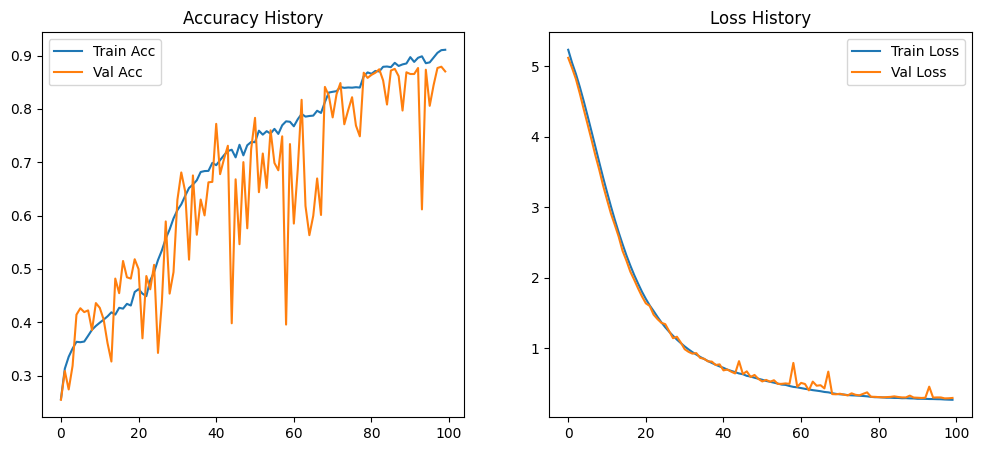

In [15]:
# -------------------80/100--------
# 7. PLOT TRAINING
# ---------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.85      0.96      0.90       301
  Kaukasoid-Indic       0.79      0.85      0.82       333
Malayan-Mongoloid       0.89      0.75      0.81       304
       Melanesoid       0.94      0.89      0.92       308

         accuracy                           0.86      1246
        macro avg       0.87      0.86      0.86      1246
     weighted avg       0.87      0.86      0.86      1246



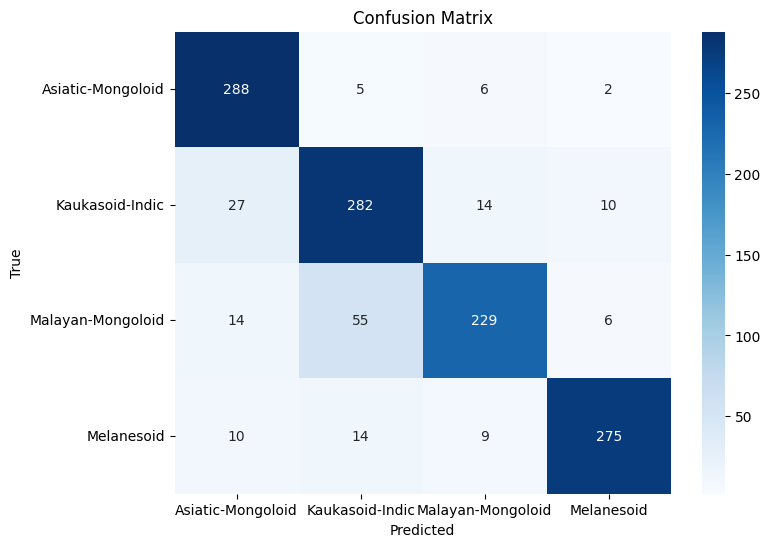

In [16]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.93      0.89      0.91       301
  Kaukasoid-Indic       0.79      0.87      0.83       333
Malayan-Mongoloid       0.83      0.82      0.82       304
       Melanesoid       0.95      0.89      0.92       308

         accuracy                           0.87      1246
        macro avg       0.87      0.87      0.87      1246
     weighted avg       0.87      0.87      0.87      1246



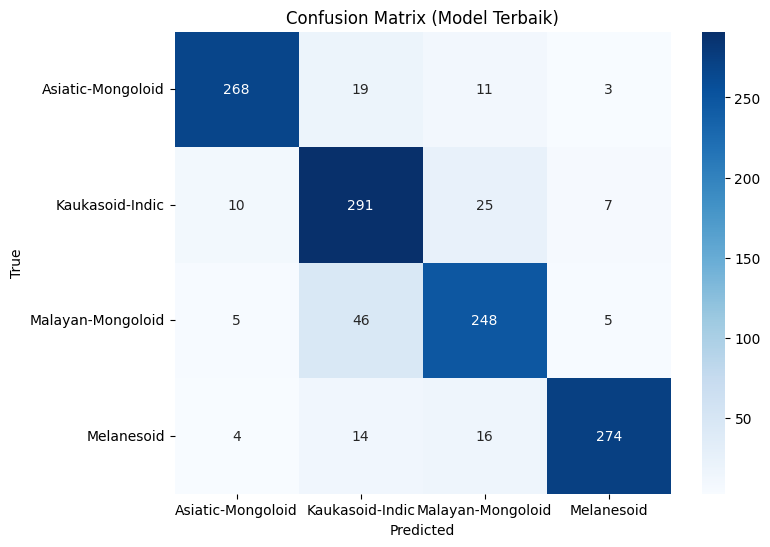

In [17]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Model_Terbaik_Tahap 1_resnet152.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})


# 2. Prediksi pakai model terbaik
y_true = test_generator.classes
y_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


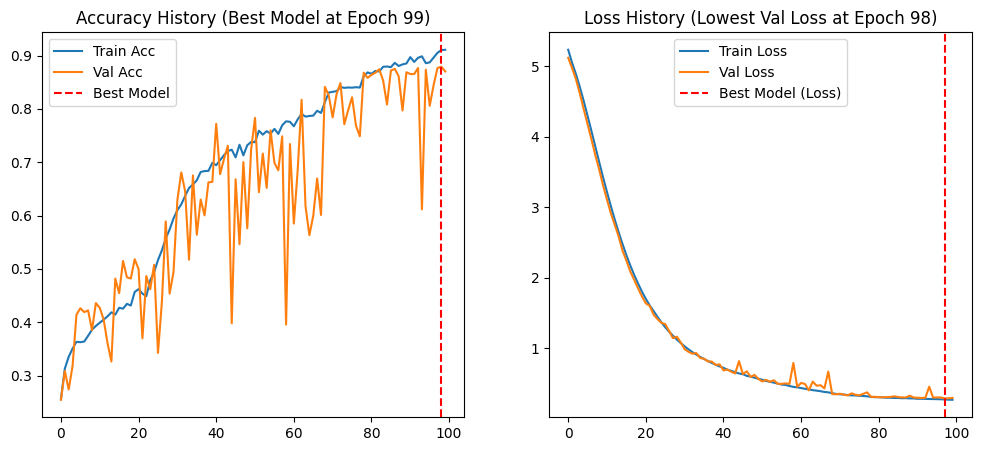

In [18]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history.history['val_loss']) + 1))

plt.show()
